In [1]:
import os
import sys
import openai
from dotenv import load_dotenv
from langchain.llms import AzureOpenAI
from langchain.chat_models.azure_openai import AzureChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain import PromptTemplate, OpenAI, LLMChain
import streamlit as st
import uuid
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from pyhive import hive
import pandas as pd
from datetime import datetime, date
from defineprompts import classPrompts
# from ChatHistory2Server import insert_query, update_query, run_query
from Embeddings import classEmbdding
from langchain.vectorstores.chroma import Chroma
from Get_answers import answer_obj
from langchain.chains.chat_vector_db.prompts import CONDENSE_QUESTION_PROMPT

load_dotenv(find_dotenv())

# openai.api_version = "2022-12-01"
openai.api_key = os.getenv("OPENAI_API_KEY")
embeddings = OpenAIEmbeddings()
print("embeddings done")

llm_model = OpenAI(model_name="gpt-3.5-turbo-0125") 
emb_obj = classEmbdding(chroma_url="./Chroma", data_url="./", subfolder="Data")
promptObj = classPrompts(prompt_file_loc="./Prompts/Prompts.xlsx")
promptObj.def_prompt_file()
file_list_Chroma = os.listdir(emb_obj.chroma_url)
vectordb = emb_obj.find_Vectordb('Head First Statistics.pdf ( PDFDrive ).pdf')

embeddings done


### Query Expansion 

In [2]:

from langchain.chat_models.azure_openai import AzureChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.chains.chat_vector_db.prompts import CONDENSE_QUESTION_PROMPT
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

# llm_model = AzureChatOpenAI(deployment_name="deployment-gpt-35-PHD-chatbot",
# model_name=model_name, openai_api_key=openai.api_key, openai_api_version = "2023-03-15-preview",openai_api_base=openai.api_base, api_type=openai.api_type, max_tokens=1000,temperature=0,seed=10,stop=['##','```','"""'])

# llm_model = AzureOpenAI(deployment_name="deployment-gpt-4-PHD-chatbot",
# model_name=model_name, openai_api_key=openai.api_key, openai_api_version = "2023-03-15-preview",openai_api_base=openai.api_base, 
# api_type=openai.api_type, max_tokens=1000,temperature=0,seed=10,stop=['##','```','\n\n','"""'])

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""",
)

llm_chain = LLMChain(llm=llm_model, prompt=QUERY_PROMPT)


In [3]:
from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
# import openai

query = "How is Normal distribution different from Poisson Distribution"
queries = llm_chain.invoke(query)

In [4]:
queries = queries["text"].split("\n")


In [5]:
queries

['How does Normal distribution contrast with Poisson Distribution?',
 'Explain the differences between Normal distribution and Poisson Distribution.',
 'What distinguishes Normal distribution from Poisson Distribution?',
 'In what ways are Normal distribution and Poisson Distribution dissimilar?',
 'Compare and contrast Normal distribution and Poisson Distribution.']

In [6]:
docs = [vectordb.similarity_search_with_relevance_scores(query=query, k=5) for query in queries]
# docs = [print(query) for query in queries]


In [7]:
# docs[0][0][0].page_content
docs

[[(Document(page_content='t more robust. When the numbers get high for Poisson and Binomial distributions, they run into trouble. Mind you, I do what I can to help out.\nHead First: You do? How?Normal: Well under certain circumstances both \nBinomial and Poisson look like me. It’s uncanny; they’re often stopped at parties by people asking them if  they’re Normal. I tell them to take it as a compliment.\nHead First: So how does that help?Normal: Well, because they look like me, it means \nthat you can actually use my probability tables to work out their probabilities. How cool is that? No more late nights slaving over a calculator; just look it up.\nHead First: I’m afraid that’s all we’ve got time for \ntonight. Normal, thanks for coming along, it’s been a pleasure.\nNormal: You’re welcome, Head First.\nThe Normal Distribution Exposed\nThis week’s interview:\nWhy Being Normal Isn’t Dullinterview with the normal distribution\nDownload at WoweBook.Com', metadata={'page': 1331, 'source': '

In [8]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        # print(doc[0].page_content)
        if doc[0].page_content not in unique_contents:
            unique_docs.append(doc[0])
            unique_contents.add(doc[0].page_content)
unique_contents = list(unique_contents)

In [9]:
len(unique_contents)

8

# Cross-encoder re-ranking

In [10]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [11]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

In [12]:
scores = cross_encoder.predict(pairs)
scores

array([-3.1980243,  4.8224363,  4.2630672,  6.3469   ,  4.0589523,
        8.337034 ,  6.6783357,  6.118797 ], dtype=float32)

In [13]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

[(8.337034,
  'you are here 4   407using the normal distribution  ii\nWe can use the normal distribution to approximate the Poisson whenever the \nPoisson distribution adopts a shape that’s like the normal, but when does this \nhappen? Let’s take a look.\nWhen λ is small...\nWhen λ is small, the shape of  the Poisson distribution is different from \nthat of  the normal distribution. The shape isn’t symmetrical, and the \ncurve looks as though it’s “pulled” over to the right.\nAs the Poisson distribution doesn’t resemble the normal for small values \nof  λ, the normal distribution isn’t a suitable appr'),
 (6.6783357,
  'ue within that range. Using the \nnormal distribution, on the other hand, you \ncan look up probabilities for whole ranges, \nand so they’re a lot easier to find. In particular circumstances you \ncan use the normal distribution to approximate the Poisson. \nIf  X ~ Po(λ) and λ > 15 then you can \napproximate X using  X ~ N(λ, λ)  \uf0a2\n\uf0a2If you’re approximating t

In [14]:
reranked_docs = [doc for _, doc in sorted_docs][0:8]
reranked_docs

['you are here 4   407using the normal distribution  ii\nWe can use the normal distribution to approximate the Poisson whenever the \nPoisson distribution adopts a shape that’s like the normal, but when does this \nhappen? Let’s take a look.\nWhen λ is small...\nWhen λ is small, the shape of  the Poisson distribution is different from \nthat of  the normal distribution. The shape isn’t symmetrical, and the \ncurve looks as though it’s “pulled” over to the right.\nAs the Poisson distribution doesn’t resemble the normal for small values \nof  λ, the normal distribution isn’t a suitable appr',
 'ue within that range. Using the \nnormal distribution, on the other hand, you \ncan look up probabilities for whole ranges, \nand so they’re a lot easier to find. In particular circumstances you \ncan use the normal distribution to approximate the Poisson. \nIf  X ~ Po(λ) and λ > 15 then you can \napproximate X using  X ~ N(λ, λ)  \uf0a2\n\uf0a2If you’re approximating the Poisson \ndistribution wi

### Lost in the middle Problem

In [15]:
from langchain_community.document_transformers import (
    LongContextReorder
)

In [16]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(reranked_docs)
reordered_docs

['ue within that range. Using the \nnormal distribution, on the other hand, you \ncan look up probabilities for whole ranges, \nand so they’re a lot easier to find. In particular circumstances you \ncan use the normal distribution to approximate the Poisson. \nIf  X ~ Po(λ) and λ > 15 then you can \napproximate X using  X ~ N(λ, λ)  \uf0a2\n\uf0a2If you’re approximating the Poisson \ndistribution with the normal distribution, then you need to apply a continuity correction to make sure your results are accurate.\uf0a2\nUse a continuity correction if you approximate the Poisson distribution \nwith the normal distribution.bullet points and no dumb questions\nDownload at WoweBook.Com',
 '412  Chapter 9Q:  You can approximate the binomial \nand Poisson distributions with the \nnormal, but what about the geometric \ndisribution? Can the normal distribution \never approximate that?\nA:  We were able to use the normal \ndistribution in place of the binomial and \nPoisson distributions because 

In [17]:
vectors = embeddings.embed_documents(reranked_docs)

In [18]:
# vectors[2]

In [19]:
# import umap
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
pca = PCA(n_components=5,svd_solver='full')
pca.fit(vectors)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
# umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

[0.23252809 0.20266261 0.16230698 0.13282402 0.09541651]
[0.45342479 0.42330594 0.37882283 0.3426935  0.2904553 ]


In [20]:
from matplotlib import pyplot as plt   
def plot_vetors(query, embeddings,vectors):
    pca = PCA(n_components=2,svd_solver='full')
    pca.fit(vectors)
    query_vector = embeddings.embed_documents([query])
    trans_global_vectors = pca.transform((vectors))
    trans_query_vector = pca.transform((query_vector))
    close_texts = vectordb.similarity_search_with_relevance_scores(query=query, k=5)
    unique_contents = []
    for i in range(len(close_texts)):
        unique_contents.append(close_texts[i][0].page_content)
    print(unique_contents)

    close_vector = embeddings.embed_documents(unique_contents)
    trans_close_vector = pca.transform((close_vector))


    plt.figure()
    plt.scatter(trans_global_vectors[:, 0], trans_global_vectors[:, 1], s=10, color='gray')
    plt.scatter(trans_query_vector[:, 0], trans_query_vector[:, 1], s=150, marker='X', color='r')
    plt.scatter(trans_close_vector[:, 0], trans_close_vector[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

    return trans_global_vectors


In [21]:
from langchain.document_loaders import PyPDFLoader
from langchain.schema import Document
from langchain.text_splitter import CharacterTextSplitter
loader_url = 'Data\Head First Statistics.pdf ( PDFDrive ).pdf'
loader = PyPDFLoader(loader_url)
document = loader.load()


document1 = [Document(page_content = '', metadata = {'source':'', 'page':0})]
for i in range(len(document)):
    n_tokens = len(document[i].page_content)
    n_tokens1=n_tokens-n_tokens%3
    source = document[i].metadata['source']

    text1 = Document(page_content=document[i].page_content[0:int(n_tokens1/3)], metadata={'source':source, 'page':3*i},)
    text2 = Document(page_content=document[i].page_content[int(n_tokens1/3):int(2*n_tokens1/3)], metadata={'source':source, 'page':3*i+1},)
    text3 = Document(page_content=document[i].page_content[int(2*n_tokens1/3):int(n_tokens)], metadata={'source':source, 'page':3*i+2},)

    document1.append(text1)
    document1.append(text2)
    document1.append(text3)

# print(j, len(document1))


In [22]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(document1)
texts_set = []
for i in range(len(texts)):
    # print(texts[i].page_content)
    texts_set.append(texts[i].page_content)
print(texts_set)

['Download', 'at Wowe', 'Book.Com', 'Advance Praise for Head First Statistics\n“Head First Statistics  is by far the most entertaining, attention-catching study guide on the market.  By \npresenting the material in an engaging manner, it provides students with a comfortable way to learn an \notherwise cumbersome subject.  The explanation of  the topics is presented in a manner comprehensible \nto students of  all levels.”\n—  A\nriana Anderson, Teaching Fellow/PhD candidate in Statistics, UCLA\n“Head First Statistics  is deceptively friendly . Breeze through the explanations and exercises and you just \nmay find yourself  raising the', 'topic of  normal vs. Poisson distribution in ordinary social conversation, \nwhich I can assure you is not advised!”\n—  G\nary Wolf, Contributing Editor, Wired  Magazine\n“Dawn Griffiths has split some very complicated concepts into much smaller, less frightening, bits of  \nstuff  that real-life people will find very easy to digest. Lots of  graphics 

In [23]:

vectors = embeddings.embed_documents(texts_set)

['Download', 'Download', 'Download', 'Download', 'Download']


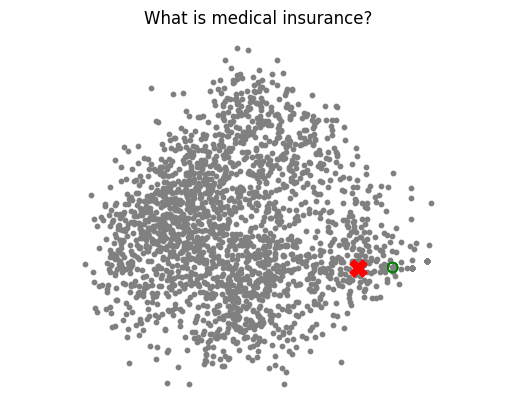

array([[ 0.25156956, -0.06219112],
       [ 0.30746195, -0.05132473],
       [ 0.28369847, -0.06357868],
       ...,
       [-0.04435104,  0.05878972],
       [-0.08781886, -0.0278104 ],
       [-0.0780113 ,  0.03704596]])

In [28]:
query = 'What is medical insurance?'
plot_vetors(query, embeddings,vectors)